
# TWITTER STREAM

*This is a condensed documentation, but the work behind it is more than meets the eye.*

Has several changes in the past months on april 29th Twitter announced the v1.1 [deprecation](https://twittercommunity.com/t/deprecation-announcement-removing-compliance-messages-from-statuses-filter-and-retiring-statuses-sample-from-the-twitter-api-v1-1/170500) api. It affects stream endpoint. So in fall october the api is now deprecated. I think (my opinion) some people may has access because it previous apps, but no more new auths. Not all endpoints are deprecated but some of them affect the streaming functionality. 

The migration guide for Api v2 stream is [here](https://developer.twitter.com/en/docs/twitter-api/tweets/volume-streams/migrate/standard-to-twitter-api-v2) and also it comparison with the v1.1.:
- auth
- retrieved fields now you have to expand for more fields

Some notes to take into account are:

- Handle languages in tweets using [lang as a tag](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query#list)
- How to [add rule doc](https://docs.tweepy.org/en/stable/streamrule.html)
- How to build a [list of tags](https://developer.twitter.com/en/docs/twitter-api/tweets/filtered-stream/integrate/build-a-rule#list)
- why i dont have all [fields](https://developer.twitter.com/en/docs/twitter-api/fields)
- To make [expansions](https://docs.tweepy.org/en/stable/streamingclient.html) and get more fields
- [how rules are made](https://github.com/tweepy/tweepy/blob/cc8dd493b1ed04b48a6dd4e47eeb9a9064f83024/tweepy/streaming.py#L1005)
- Rules are storaged in your account. So if you want to do a new search make sure you deleted the previous ones

# 1. Required libraries


In [1]:
import tweepy
import csv
from csv import writer

from tweepy import StreamingClient, OAuthHandler

import json
import sys
import time
import datetime

In [2]:
tweepy.__version__

'4.12.1'

# 2. Get the token:

Get the token in the twitter dev pages and paste below:

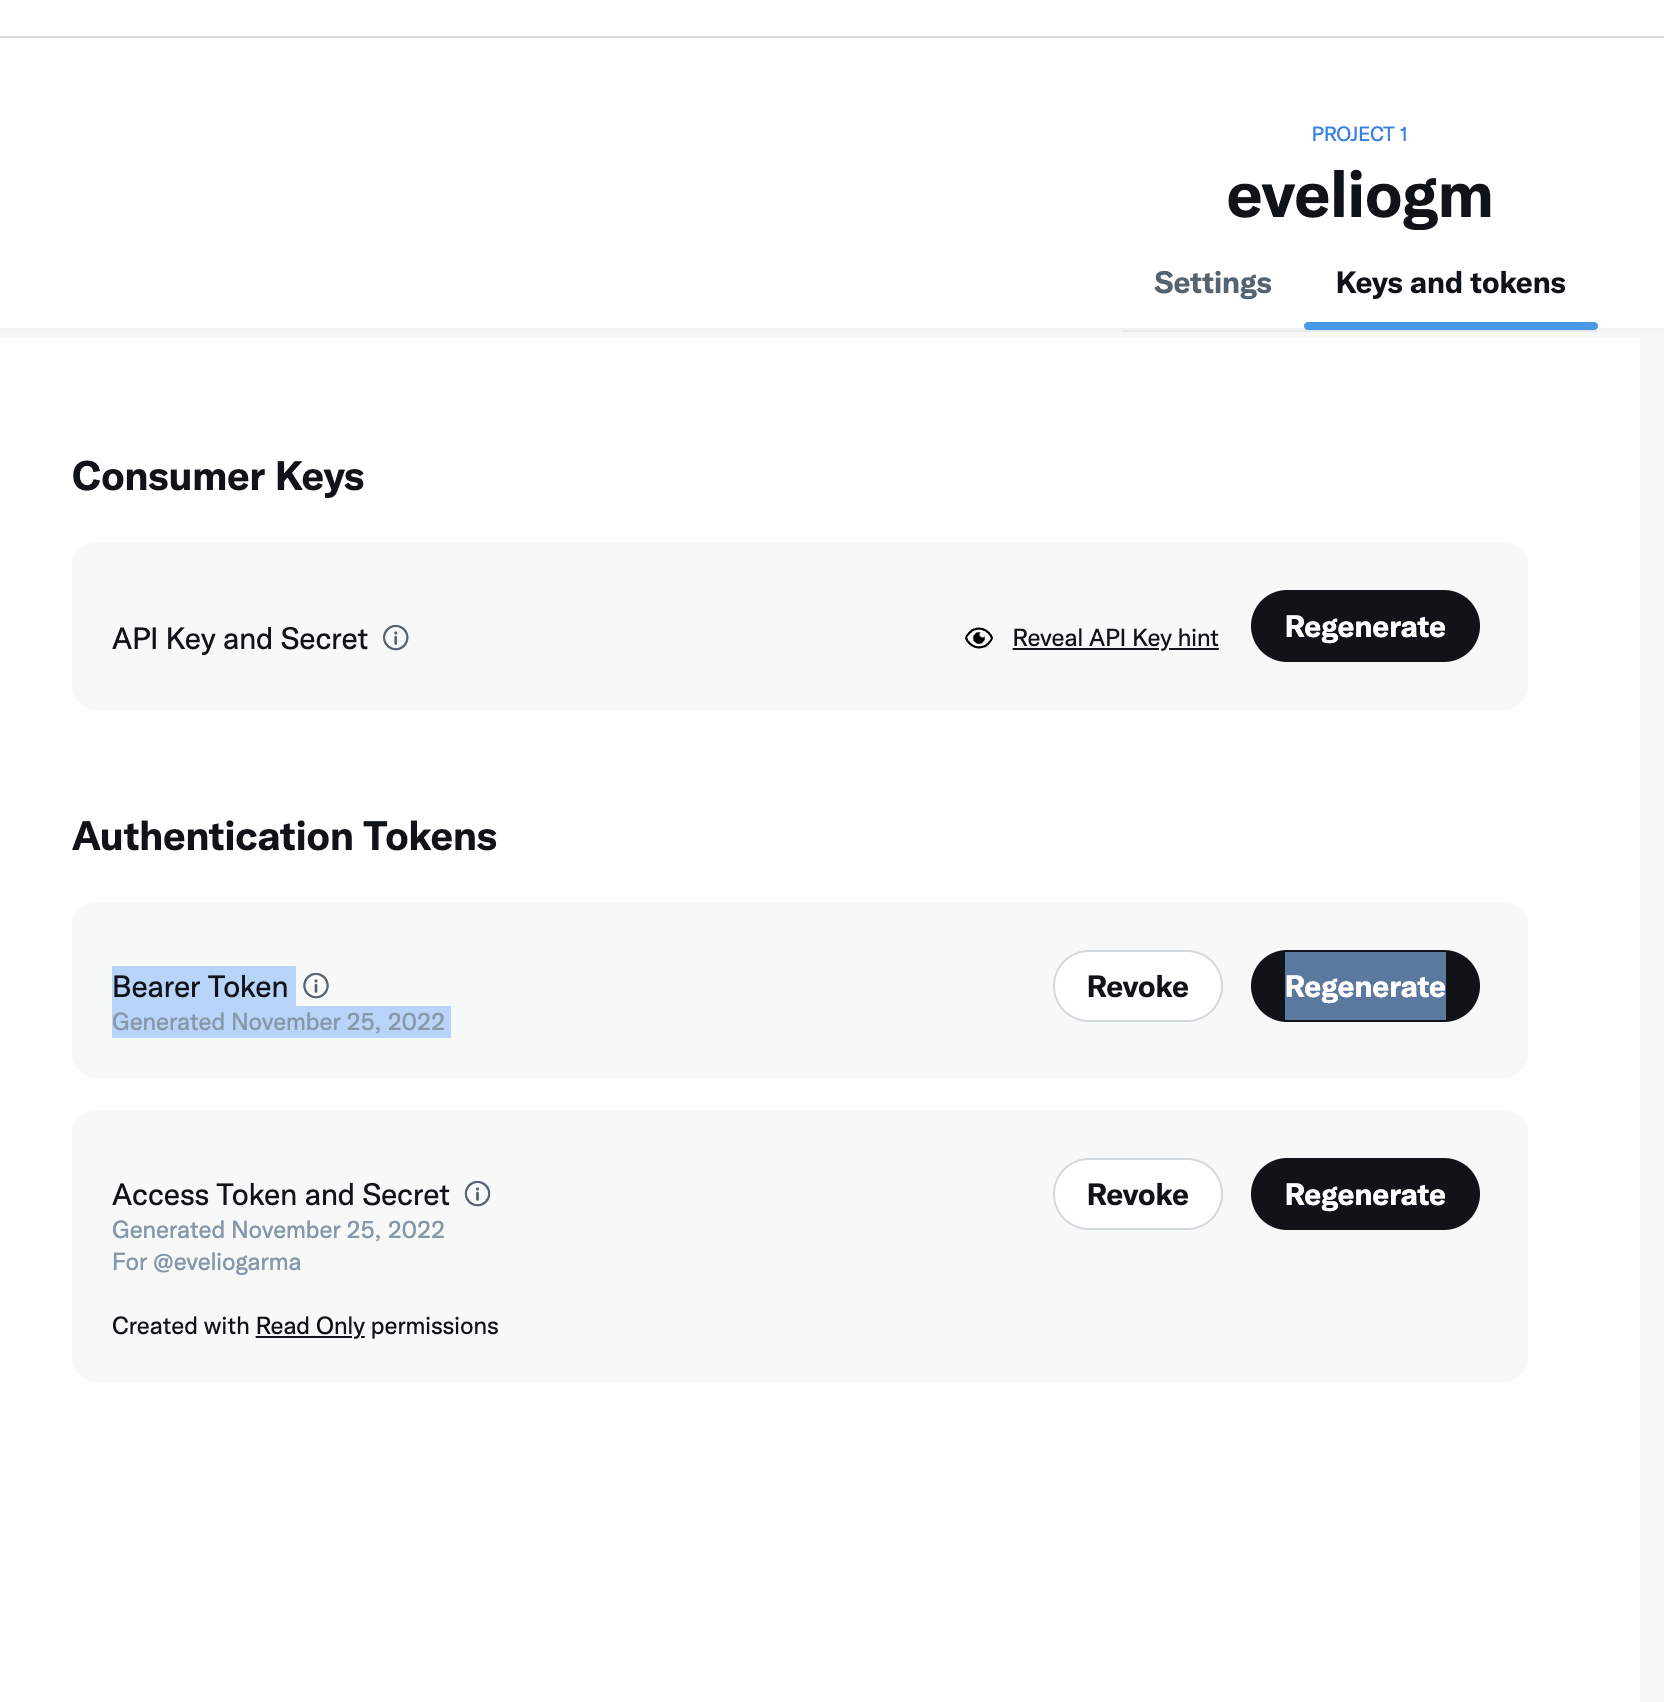


In [3]:
bearer_token = "AAAAAAAAAAAAAAAAAAAAAMfrjgEAAAAAZgF4KJC8t4znThmxA8uimtj8Ktc%3Dj6qezOPncyaFTkl667OMKRW1jfacqFPmdl8EuLShyg2UuunD4X"

# 3. Parameters

## 3.1. Data Track

In [31]:
data_track = ['Feliz', 'navidad', 'loteria']

max_tweets = 10

timeout = 10

## 3.2. File Name

In [32]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H%M%S')
data_storage = data_track[0]
file_name = data_storage + st + '.csv'
file_name

'Feliz2022-12-23 133057.csv'

## 3.2. TimeOut Setup

In [33]:
timeout = 1 * 60 * timeout
timeout = time.time() + timeout
#file_load = FloatProgress(min=0, max=100)

# 4. Connection

## 4.1. Started at

In [34]:
datetime.datetime.utcnow().strftime("%a %b %d %H:%M:%S %Z %Y")

'Fri Dec 23 12:30:58  2022'

## 4.2. Add tag to filter

In [35]:
def and_tag(value,tag):
    return f' {tag}:{value}'

## 4.3. Current file loading progress

In [36]:
#Create the listener class that receives and saves tweets
class listener(StreamingClient):
    __num_tweets = 0.0
    __max_tweets = 10
    __values = []
    #On init, set the counter to zero and create a progress bar
#     def __init__(self, api=None):
#         self.num_tweets = 0.0
#         #self.pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=max_tweets).start()
        
    #When data is received, do this
    def on_data(self, data):
        #Append the tweet to the 'tweets.txt' file        
        #with open(file_name, 'a') as tweet_file:
        with open(file_name, 'a', newline='', encoding='utf-8') as tweet_file:
            
            csv = writer(tweet_file, lineterminator = '\n')
            #c = csv.writer(open("Myfile.csv", 'w',  newline='', encoding='utf-8'))
            while self.__num_tweets < max_tweets:               
                tweet = json.loads(data)
                print(data)
                # print(data)
                # disable this line once your testing is done
                values = []
                # Pull out as any fields as you can. Examples given in the below
                
                # GENERATE THE HEADERS
                if self.__num_tweets == 0:
                    values = []
                    for key in tweet:
                        if (isinstance(tweet[key],dict) or isinstance(tweet[key],list)) and len(tweet[key]) > 1:
                            for key_2 in tweet[key]:
                                values.append( key+key_2)
                        else:
                            values.append(key)
                    csv.writerow(values)
                
                values = []
                for key in tweet:
                    print(f'KEY first: {key}')
                    if (isinstance(tweet[key],dict) or isinstance(tweet[key],list)) and len(tweet[key]) > 1:
                        for key_2 in tweet[key]:
                            print(f'KEY second: {key_2}')
                            values.append( tweet[key][key_2])
                    else:
                        values.append(tweet[key])
                
                self.__values.append(values)
                csv.writerow(values)
                self.__num_tweets += 1
                if self.__num_tweets == max_tweets:
                    #file_load.value = 0
                    tweet_file.close()
                    return False
                else: 
                    #end loop, maximum reached
                    return self.__values
        #return False
    #Handle any errors that may occur
    def on_error(self, status):
        print (status)


## 4.4. Delete rules
Apparently rules are storaged within your account. So if you dont delete it after using it you will have multiple rules

In [37]:
def reset_rules(twitterStream):
    rules_ids = []
    rules = twitterStream.get_rules()
    for rule in rules.data:
        rules_ids.append(rule[2])
    if len(rules_ids) > 0:
        s = twitterStream.delete_rules(rules_ids)
    print(s)

## 4.5. Stream

In [39]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H%M%S')
file_name = data_storage + st + '.csv'
while time.time() < timeout:
    #Prevent error 420: Connection overlap
    time.sleep(2)
    #Use the listener class for stream processing
    twitterStream = listener(bearer_token)
    rules = []
    for track in data_track:
        rules.append(f'{track}')
    rules = ' OR '.join(rules)
    rules = f'({rules})'
    rules = rules + and_tag('es','lang')
    print(rules)
    twitterStream.add_rules(tweepy.StreamRule(rules))

    #Filter for these topics
    print(twitterStream.get_rules())
    response = twitterStream.filter(
        tweet_fields = ['author_id','created_at','text','source','lang','geo'],
        user_fields = ['name','username','location','verified'],
        expansions = ['geo.place_id', 'author_id'],
        place_fields = ['country','country_code']
    )
    reset_rules(twitterStream)
    if time.time() >= timeout:
        print ('close')
        break

(Feliz OR navidad OR loteria) lang:es
Response(data=[StreamRule(value='(Feliz OR navidad OR loteria) lang:es', tag=None, id='1606266420706287619')], includes={}, errors=[], meta={'sent': '2022-12-23T12:32:13.580Z', 'result_count': 1})
b'{"data":{"author_id":"50660080","created_at":"2022-12-23T12:32:12.000Z","edit_history_tweet_ids":["1606266420169527298"],"geo":{},"id":"1606266420169527298","lang":"es","text":"RT @dievalen: \xc2\xbfCU\xc3\x81NDO SACAR LOS RESIDUOS EN NAVIDAD? \xf0\x9f\x8e\x85\xf0\x9f\x8e\x84\\nTe dejamos el esquema de recolecci\xc3\xb3n para que lo tengas en cuenta y evitemos que se\xe2\x80\xa6"},"includes":{"users":[{"id":"50660080","location":"Tres de Febrero  Buenos Aires","name":"Pablo H. Casna","username":"pcasna","verified":false},{"id":"124539002","location":"Buenos Aires, Argentina","name":"Diego Valenzuela","username":"dievalen","verified":false}]},"matching_rules":[{"id":"1606266420706287619","tag":""}]}'
KEY first: data
KEY second: author_id
KEY second: crea

KeyboardInterrupt: 